In [3]:
#####################
#####  Modules  #####
#####################

# Arrays and handling data
import numpy as np
import pandas as pd
import math

from astropy.io import fits # Astronomical files

# Plotting data
import matplotlib
from matplotlib import pyplot as plot
from mpl_toolkits.axes_grid1 import make_axes_locatable # Color log
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes # Zoom
from mpl_toolkits.axes_grid1.inset_locator import mark_inset # Zoom

# Pulling data
import requests
import json
from urllib.parse import quote as urlencode   

import os # Accessing local files
import sys
import pickle

# Creating apertures
#from photutils.aperture import RectangularAnnulus # For annulus
from photutils.aperture import EllipticalAperture
from photutils.aperture import RectangularAperture
from photutils.aperture import ApertureStats
from photutils.aperture import aperture_photometry
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS # Converting between pixels and WCS
from astropy.coordinates import Angle # Converting from degrees for aperture
from mpfit import mpfit # Making a gaussian fit for the aperture

from IPython.display import clear_output # Clearing output to not lag notebook

import pdb # For viewing and stopping the program

# Fixing time offsets
from astropy.time import Time
import datetime
import time
import calendar

In [20]:
# Getting ra, dec and radius from TIC ID from the TIO Catalog

'''
tic_ID = "TIC 155657581" # SIMBAD4 flickers really brightly so it should be easy to spot

ra = "206.395293725348"
dec = "79.3967479665581"
cutout_size = "600" # Arcseconds

radius = str(float(cutout_size) * float(math.sqrt(2)) / float(3600)) # Search radius. Cutout_size * root 2 / 2 for each side. Needs to be in decimal degrees 1/120 degrees
print(radius)

period = 0.3681414 # days


tic_ID = "TIC 367102581" # TOI 1522.01

ra = "314.269036"
dec = "78.674917"
cutout_size = "180" # Arcseconds

radius = str(float(cutout_size) * float(math.sqrt(2)) / float(3600)) # Search radius. Cutout_size * root 2 / 2 for each side. Needs to be in decimal degrees 1/120 degrees
print(radius)

period = 2.97962 # days
'''

tic_ID = "TIC 230075120" # TOI 4110.01
ra = "244.441326477867"
dec = "69.4476688171414"
#tic_ID = "TIC 230075121" # Actual signal of TOI 4110.01
#ra = "244.448592169577"
#dec = "69.439439507217"

cutout_size = "350" #"180" # Arcseconds
radius = str(float(cutout_size) * float(math.sqrt(2)) / float(3600)) # Search radius. Cutout_size * root 2 / 2 for each side. Needs to be in decimal degrees 1/120 degrees
print(radius)

period = 0.7676704 # days

0.13749298523071757


In [15]:
# Query using MAST to get the cone and all the stars inside the cone

def mast_query(request):
    request_url = "https://mast.stsci.edu/api/v0/invoke" # Base URL
    
    version = ".".join(map(str, sys.version_info[:3])) # Grab Python version
    
    headers = { # Create HTTP header variables
        "Content-type": "application/x-www-form-urlencoded",
        "Accept": "text/plain",
        "User-agent": "python-requests/" + str(version)
    }
    
    # Encoding the request as a JSON string
    req_string = json.dumps(request)
    req_string = urlencode(req_string)
    
    response = requests.post(str(request_url), data = "request=" + str(req_string), headers = headers) # Perform the HTTP request
    
    # Pull out the headers and response content
    head = response.headers # Content where head is the response HTTP headers
    content = response.content.decode("utf-8") # Returned data
    return head, content

def tic_advanced_search_position_rows():
    request = {"service": "Mast.Catalogs.Filtered.Tic.Position.Rows",
               "format": "json",
               "params": {
                   "columns": "*",
                   "filters": [],
                   "ra": float(ra),
                   "dec": float(dec),
                   "radius": float(radius)
               }
    }
    
    headers, out_string = mast_query(request)
    out_data = json.loads(out_string)
    dataframe = pd.DataFrame(out_data["data"])
    
    return dataframe

In [11]:
#def add_new_frame(time_of_frame, image_median, image_filter, brightness, px, py, x0, sigma_x, y0, sigma_y, theta):
def add_new_frame(time_of_frame, image_median, image_filter, x0, sigma_x, y0, sigma_y, theta):
    all_star_data.append({
        "time": time_of_frame
        , "image_median": image_median
        , "image_filter": image_filter
        , "x0": x0
        , "sigma_x": sigma_x
        , "y0": y0
        , "sigma_y": sigma_y
        , "theta": theta
    })


def calculate_time_offset(julian_days, mini_ra, mini_dec, pm_ra, pm_dec):
    times = [julian_days]
    t = Time(times, format = "jd", scale = "utc")
    date = datetime.datetime.strptime(t.iso[0][:10], "%Y-%m-%d")
    if calendar.isleap(int(t.iso[0][:4])):
        days = 366
    else:
        days = 365
    
    seconds_in_months = []
    for month in range(0, int(t.iso[0][5:7]) - 1): # Iterating through one less month than the date's month because those days can just be tacked on
        seconds_in_months.append((calendar.monthrange(int(t.iso[0][:4]), month + 1)[1]) * 24 * 60 * 60) # Seconds in month
    seconds_in_months.append(int(t.iso[0][8:10]) * 24 * 60 * 60)
    
    time_string = time.strptime(t.iso[0][11:],"%H:%M:%S.%f")
    seconds_in_time = datetime.timedelta(hours = time_string.tm_hour, minutes = time_string.tm_min, seconds = time_string.tm_sec).total_seconds() # Seconds of my timestamp from the TIME ONLY
    
    datetime_decimal = int(t.iso[0][:4]) + ((sum(seconds_in_months) + seconds_in_time) / (days * 24 * 60 * 60))
    print(datetime_decimal)
    
    pm_ra = pm_ra / 3600000 # 1 degree = 3600000 milliarcseconds. pmRA and pmDEC need to be converted from (milliarc seconds)/year to degrees/year
    pm_dec = pm_dec / 3600000
    delta_ra = ((datetime_decimal - 2000.0) * pm_ra) / (np.cos(np.deg2rad(mini_dec)))
    corrected_ra = mini_ra + delta_ra
    delta_dec = (datetime_decimal - 2000.0) * pm_dec
    corrected_dec = mini_dec + delta_dec
    
    return corrected_ra, corrected_dec


def create_2D_gaussian(x_data_tuple, parameters): # Creating the 2D gaussian
    (x, y) = x_data_tuple 
    
    amplitude, x0, sigma_x, y0, sigma_y, theta, offset = parameters
    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    
    g = offset + amplitude*np.exp( - (a*((x-x0)**2) + 2*b*(x-x0)*(y-y0)+ c*((y-y0)**2)))
    return g.ravel()


def myfunct(parameters, fjac = None, x = None, y = None, err = None, brightness = None): # If fjac == None, then partial derivatives should not be computed. It will always be None if MPFIT is called with default flag
    model = create_2D_gaussian((x, y), parameters)
    status = 0 # Non-negative status value means MPFIT should continue, negative means stop the calculation
    return [status, ((brightness - model.reshape(int(math.sqrt(model.shape[0])), int(math.sqrt(model.shape[0]))))).reshape(model.shape[0])]


def find_ellipse_from_2D_gaussian_fit(image_max, image_median, subarray):
    parameters = [image_max - image_median, (len(subarray[0]) / 2), 2, (len(subarray[0]) / 2), 2, 0, image_median] # A (amplitude -- like the brightest pixel - the noise), x0 (actual x center of star), y0 (actual y center of star), sigma_x (half the width of the star in the x direction), sigma_y (half the width of the star in the y direction), c (vertical shift -- noise)
    
    x = np.arange(subarray.shape[0]) # Columns of subarray -- NOT BRIGHTNESSES
    y = np.arange(subarray.shape[1]) # Rows of subarray -- NOT BRIGHTNESSES
    x, y = np.meshgrid(x, y)
    
    data = create_2D_gaussian((x, y), parameters)
    
    start_parameters = parameters # Choose starting values for parameter you are trying to fit. Roughly like what they should be
    parameters_info = [ # Step sizes for parameters. If fixed == True, then it will stay constant and not fit for that parameter, so we want all of them to be False
        {"fixed": False, "step": 1e1, "mpprint": 0} # Amplitude
        , {"fixed": False, "step": 1e-2, "mpprint": 0} # x0
        , {"fixed": False, "step": 1e-3, "mpprint": 0} # sigma_x
        , {"fixed": False, "step": 1e-2, "mpprint": 0} # y0
        , {"fixed": False, "step": 1e-3, "mpprint": 0} # sigma_y
        , {"fixed": False, "step": 1e-2, "mpprint": 0} # Theta
        , {"fixed": False, "step": 1e0, "mpprint": 0} # Offset
    ]
    
    fa = {"x": x, "y": y, "brightness": subarray}
    model = mpfit(myfunct, start_parameters, functkw = fa, parinfo = parameters_info, maxiter = 100, nprint = 0) #, quiet = "quiet")
    
    return model.params[1], model.params[2], model.params[3], model.params[4], model.params[5] # x0 (center), sigma_x (semimajor), y0 (center), sigma_y (semiminor), theta


def get_brightness(fits_image_without_median, subarray_x_length, subarray_y_length, px, py, x0, sigma_x, y0, sigma_y, theta):
    number_of_sigma = 3
    major_axis = max(number_of_sigma * sigma_x, number_of_sigma * sigma_y) # a is always bigger
    minor_axis = min(number_of_sigma * sigma_x, number_of_sigma * sigma_y) # b is always smaller
    
    positions_dictionary = {"px": np.array(px) + x0 - (subarray_x_length / 2), "py": np.array(py) + y0 - (subarray_x_length / 2)}
    positions_dataframe = pd.DataFrame(positions_dictionary)
    positions_dataframe["point"] = list(zip(positions_dataframe["px"], positions_dataframe["py"]))
    
    aperture = EllipticalAperture(list(positions_dataframe["point"]), major_axis, minor_axis, theta = Angle(str(theta) + "d")) # Either takes Angle() or radians but Angle() was more accurate (takes in degrees rather than conversion)
    aperture_area = aperture.area_overlap(fits_image_without_median)
    total_background = np.median(fits_image_without_median) * aperture_area[0]
    total_background = np.median(fits_image_without_median) * np.array(aperture_area)
    
    phot_table = aperture_photometry(fits_image_without_median, aperture)
    phot_background_subtraction = phot_table["aperture_sum"] - total_background
    
    return np.array(phot_background_subtraction)


def get_offset(fits_image, px, py):
    _, median, _ = sigma_clipped_stats(fits_image, sigma = 5.0)
    fits_image_without_median = fits_image - median # Subtract background from the data
    
    subarray = fits_image_without_median # fits_image_without_median[int(py) - 10 : int(py) + 10, int(px) - 10 : int(px) + 10]
    for subtraction_index in range(10, 1, -1):
        print(subtraction_index)
        if ((int(px) - subtraction_index) > 0) and ((int(py) - subtraction_index) > 0) and ((int(px) + subtraction_index) < len(fits_image[0])) and ((int(py) + subtraction_index) < len(fits_image)):
            subarray = fits_image_without_median[int(py) - subtraction_index : int(py) + subtraction_index, int(px) - subtraction_index : int(px) + subtraction_index]
            break
        else:
            print((int(px) - subtraction_index), (int(px) + subtraction_index), (int(py) - subtraction_index), (int(py) + subtraction_index))
    
    print("Subarray shape: " + str(subarray.shape))
    x0, sigma_x, y0, sigma_y, theta = find_ellipse_from_2D_gaussian_fit(np.max(fits_image), median, subarray) # Degrees
    
    return fits_image_without_median, len(subarray[0]), len(subarray), x0, sigma_x, y0, sigma_y, theta


def open_fits_file(fits_URL, mini_ra, mini_dec):
    fits_file = fits.open(fits_URL) # fits can open URLS directly without needing to save the data as a .fits file")
    fits_image = np.array(fits_file[0].data)
    fits_header = fits_file[0].header
    target_w = WCS(fits_file[0].header)
    print("Picture size: " + str(len(fits_image[0])) + " by " + str(len(fits_image)))
    
    '''
    figure, ax = plot.subplots()
    figure.set_figheight(20)
    figure.set_figwidth(20)
    img = ax.imshow(fits_image, norm = matplotlib.colors.LogNorm()) # Log color scale to more easily see the contrast and see more stars. FLip the image data vertically to check with ds9
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size = "5%", pad = 0.05)
    colorbar = figure.colorbar(img, cax = cax, orientation = "vertical")
    colorbar.set_ticks([np.mean(fits_image), np.median(fits_image), 1000, 10000, np.max(fits_image), np.min(fits_image)])
    colorbar.set_ticklabels(["Mean: " + str(np.mean(fits_image)), "Median: " + str(np.median(fits_image)), str(1000), str(10000), "Max: " + str(np.max(fits_image)), "Min: " + str(np.min(fits_image))])
    plot.show()
    '''
    
    GET_RID_OF = target_star_index # 131 #79 #342 # 2 # Becomes the actual target_star_index but right now I am using the fake cone so even though cone[342] is correct, the np arrays have it under array[2]
    
    all_star_ra, all_star_dec = calculate_time_offset(float(fits_header["OBSJD"]), np.array(cone["ra"]), np.array(cone["dec"]), np.array(cone["pmRA"]), np.array(cone["pmDEC"]))
    print("WCS: (" + str(all_star_ra[int(np.where(cone["ID"] == int(tic_ID.split()[1]))[0][0])]) + ", " + str(all_star_dec[int(np.where(cone["ID"] == int(tic_ID.split()[1]))[0][0])]) + ") ")
    all_star_px, all_star_py = target_w.wcs_world2pix(all_star_ra, all_star_dec, 1)
    print("Target pixels: (" + str(all_star_px[GET_RID_OF]) + ", " + str(all_star_py[GET_RID_OF]) + ")")
    
    # Calculating the offsets with the gaussian fit
    fits_image_without_median, subarray_x_length, subarray_y_length, x0, sigma_x, y0, sigma_y, theta = get_offset(fits_image, float(all_star_px[GET_RID_OF]), float(all_star_py[GET_RID_OF]))
    add_new_frame(float(fits_header["OBSJD"]), np.median(fits_image), fits_header["filter"], x0, sigma_x, y0, sigma_y, theta)
    
    # Getting all the brightnesses
    all_star_from_cone_brightness = get_brightness(fits_image_without_median, subarray_x_length, subarray_y_length, all_star_px, all_star_py, x0, sigma_x, y0, sigma_y, theta)
    for i in range(len(all_star_from_cone_brightness)):
        all_star_data[-1][str(cone.iloc[i]["ID"]) + "_brightness"] = all_star_from_cone_brightness[i]
        all_star_data[-1][str(cone.iloc[i]["ID"]) + "_px"] = all_star_px[i]
        all_star_data[-1][str(cone.iloc[i]["ID"]) + "_py"] = all_star_py[i]
    
    # Saving the dataframe to a .csv file
    all_star_dataframe = pd.DataFrame(all_star_data)
    all_star_dataframe.to_csv("All_Star_Data_3.csv")
    
    fits_file.close()
    
    print("Saving frame data")
    print("..................")

In [13]:
def get_ZTF_link(table, picture_number):
    file_fracday = str(table.at[picture_number, "filefracday"]) # yyyy + mm + dd + fracday
    year = str(file_fracday[:4]) # yyyy
    month = str(file_fracday[4:6]) # mm
    day = str(file_fracday[6:8]) # dd
    fracday = str(file_fracday[8:])
    padded_field = str("000" + str(table.at[picture_number, "field"])) # 000 + field
    filter_code = str(table.at[picture_number, "filtercode"])
    padded_ccdid = str(table.at[picture_number, "ccdid"]) # ccdid
    image_type_code = str(table.at[picture_number, "imgtypecode"]) # imgtypecode
    qid = str(table.at[picture_number, "qid"])
    suffix = "sciimg.fits" # Primary science image
    
    fits_URL = "https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/" + str(year) + "/" + str(month) + str(day) + "/" + str(fracday) + "/ztf_" + str(file_fracday) + "_" + str(padded_field) + "_" + str(filter_code) + "_c" + str(padded_ccdid) + "_" + str(image_type_code) + "_q" + str(qid) + "_" + str(suffix) # Entire .fits file
    if not cutout_size == "":
        fits_URL += "?center=" + str(ra) + "," + str(dec) + "&size=" + str(cutout_size) + "arcsec&gzip=false" # For downloading .fits cutout
    
    return fits_URL

def get_ZTF_links(star_number, mini_ra, mini_dec, cutout_size): # Download the ZTF image
    pd.set_option("display.max_columns", None) # Setting up the pandas dataframe table
    
    # Get the list of metadata required to create the links
    metadata_URL = "https://irsa.ipac.caltech.edu/ibe/search/ztf/products/sci?POS=" + str(mini_ra) + "," + str(mini_dec)
    metadata_response = requests.get(metadata_URL)
    save_table_name = "ogfile.txt" # All different stars from cone
    open(save_table_name, "wb").write(metadata_response.content) # Save the file because the request is 1 line but once the file is saved it splits it up into many lines which can be read into dataframes
    
    # Cleaning up the metadata into a neat dataframe
    table = ""
    with open(save_table_name) as saved_table_file:
        lines = saved_table_file.readlines()
        headers = lines[90].replace(" ", "").split("|")[1:-1]
        headers.insert(19, "obstime") # Adding the times which are separated by spaces so pandas can use " " as a delimeter
        headers.insert(45, "ipac_pub_time")
        
        table = pd.read_table(save_table_name, skiprows = 94, names = headers, delim_whitespace = True) # After row 94 is the data, but 91 is the header
        saved_table_file.close()
    
    print(str(len(table)) + " total frames")
    for picture_number in range(len(table)): #0, 10): # For each frame for the lightcurve of the same picture -- same star, different time
        clear_output(wait = True) # Clearing the output so the jupyter doesn't crash
        print("\n\n\nStar " + str(star_number) + "   Frame " + str(picture_number))
        
        fits_URL = get_ZTF_link(table, picture_number) # Creating the link for the .fits file
        print(fits_URL)
        
        # Opening and analyzing the .fits file
        try:
            open_fits_file(fits_URL, float(mini_ra), float(mini_dec))
        except:# ValueError as e: # Just needs to be except to pass correctly
            print("DOWN HERE Failed and skipped: ")# + str(e))
            pass

In [19]:
start_time = time.time() # Starting the timer

# Getting the cone
cone = tic_advanced_search_position_rows()
global cone
cone["pmRA"] = cone["pmRA"].fillna(0) # Replace with zero will make sure there is no time offset but it won't crash because not all the pmRA and pmDEC values are in the cone
cone["pmDEC"] = cone["pmDEC"].fillna(0)
#cone.to_csv("Cone.csv")
#open("cone2.txt", "w").write(str(cone)) # Save the cone as a file because it is too large
#cone = cone[(cone["ID"] == 155657581) | (cone["ID"] == 155657569) | (cone["ID"] == 155657576)] # My fake cone for testing
print("Cone length: " + str(len(cone)))
#hi
all_star_data = []

# Finding where the target star is inside the cone
print(np.where(cone["ID"] == int(tic_ID.split()[1]))[0][0])
print(cone.iloc[131])
#print(cone.at[342, "ID"])
#print(np.where(cone["ID"] == 144065906)) # 26
#print(np.where(cone["ID"] == 144065863)) # 7
target_star_index = 177 #131 #79 #342 # int(np.where(cone["ID"] == int(tic_ID.split()[1]))[0][0]) # 342 in normal cone and 342 in fake cone (because I just took those rows out)
print("Target star is at index " + str(target_star_index))

# Creating the path
if not os.path.exists("SIMBAD4_Images/" + str(target_star_index) + "_3"):
    os.makedirs("SIMBAD4_Images/" + str(target_star_index) + "_3")

get_ZTF_links(target_star_index, str(ra), str(dec), str(cutout_size)) # Getting the links

print("Done!")
print("Time elapsed: " + str(datetime.timedelta(seconds = (time.time() - start_time)))) # Printing the change in time and formatting it in a more readable format than just seconds

Cone length: 847


NameError: name 'hi' is not defined

In [ ]:
# Testing the accuracy of my apertures by finding the ratios of comparison stars and their brightnesses (which should be basically the same from frame to frame)

def testing_apertures(fits_URL, mini_ra, mini_dec):
    # Getting .fits file information into easier-to-use numpy arrays and dictionaries
    fits_file = fits.open(fits_URL) # fits can open URLS directly without needing to save the data as a .fits file")
    fits_image = np.array(fits_file[0].data)
    fits_header = fits_file[0].header
    
    # Setting the pixel coordinate edges from the shape of the .fits file
    target_w = WCS(fits_header)
    target_px, target_py = target_w.wcs_world2pix(float(mini_ra), float(mini_dec), 1)
    
    comparison_star_1 = [155657569, 206.422233922412, 79.3514599041794, 14.5154] # row 336 in cone # TIC ID, ra, dec, gaiarp (gaia magnitude)
    comparison_star_2 = [155657576, 206.420747734342, 79.3740998898516, 15.9834] # row 338 in cone
    comparison_star_1_px, comparison_star_1_py = target_w.wcs_world2pix(float(comparison_star_1[1]), float(comparison_star_1[2]), 1)
    comparison_star_2_px, comparison_star_2_py = target_w.wcs_world2pix(float(comparison_star_2[1]), float(comparison_star_2[2]), 1)
    
    # Plotting the image so I know what is happening (and hopefully to show everything is working)
    figure, ax = plot.subplots()
    figure.set_figheight(20)
    figure.set_figwidth(20)
    img = ax.imshow(fits_image, norm = matplotlib.colors.LogNorm()) # Log color scale to more easily see the contrast and see more stars. FLip the image data vertically to check with ds9
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size = "5%", pad = 0.05)
    colorbar = figure.colorbar(img, cax = cax, orientation = "vertical")
    colorbar.set_ticks([np.mean(fits_image), np.median(fits_image), 1000, 10000, np.max(fits_image), np.min(fits_image)])
    colorbar.set_ticklabels(["Mean: " + str(np.mean(fits_image)), "Median: " + str(np.median(fits_image)), str(1000), str(10000), "Max: " + str(np.max(fits_image)), "Min: " + str(np.min(fits_image))])
    ax.add_patch(matplotlib.patches.Circle((comparison_star_1_px, comparison_star_1_py), 7.5, fill = False, color = "blue"))
    ax.add_patch(matplotlib.patches.Circle((comparison_star_2_px, comparison_star_2_py), 7.5, fill = False, color = "orange"))
    plot.show()
    
    comparison_star_1_brightness, comparison_star_1_offset = get_brightness_and_offset_simple_version(fits_image, comparison_star_1_px, comparison_star_1_py)
    print("Photutils 1: " + str(comparison_star_1_brightness))
    comparison_star_2_brightness, comparison_star_2_offset = get_brightness_and_offset_simple_version(fits_image, comparison_star_2_px, comparison_star_2_py)
    print("Photutils 2: " + str(comparison_star_2_brightness))
    
    #print("Simple with median 1: " + str(np.sum(fits_image[int(comparison_star_1_py) - 10 : int(comparison_star_1_py) + 10, int(comparison_star_1_px) - 10 : int(comparison_star_1_px + 10)] - np.median(fits_image))))
    #print("Simple with median 2: " + str(np.sum(fits_image[int(comparison_star_2_py) - 10 : int(comparison_star_2_py) + 10, int(comparison_star_2_px) - 10 : int(comparison_star_2_px + 10)] - np.median(fits_image))))
    #print("Simple with median 1: " + str(np.sum(fits_image[int(comparison_star_1_py) - 5 : int(comparison_star_1_py) + 5, int(comparison_star_1_px) - 5 : int(comparison_star_1_px + 5)] - np.median(fits_image))))
    #print("Simple with median 2: " + str(np.sum(fits_image[int(comparison_star_2_py) - 5 : int(comparison_star_2_py) + 5, int(comparison_star_2_px) - 5 : int(comparison_star_2_px + 5)] - np.median(fits_image))))
    
    
    # Printing the final ratio and magnitudes
    #print(np.sum(fits_image[int(comparison_star_1_py) - 10 : int(comparison_star_1_py) + 10, int(comparison_star_1_px) - 10 : int(comparison_star_1_px + 10)] - np.median(fits_image)) / np.sum(fits_image[int(comparison_star_2_py) - 10 : int(comparison_star_2_py) + 10, int(comparison_star_2_px) - 10 : int(comparison_star_2_px + 10)] - np.median(fits_image)))
    #print(np.sum(fits_image[int(comparison_star_1_py) - 5 : int(comparison_star_1_py) + 5, int(comparison_star_1_px) - 5 : int(comparison_star_1_px + 5)] - np.median(fits_image)) / np.sum(fits_image[int(comparison_star_2_py) - 5 : int(comparison_star_2_py) + 5, int(comparison_star_2_px) - 5 : int(comparison_star_2_px + 5)] - np.median(fits_image)))
    print(str(comparison_star_1_brightness / comparison_star_2_brightness) + " ~ " + str(2.512 ** 1.7))
    print("delta m ~ " + str(np.log(comparison_star_1_brightness / comparison_star_2_brightness) / np.log(2.512)))
    
    return comparison_star_1_brightness / comparison_star_2_brightness


ratio_1 = testing_apertures("SIMBAD4_Images/342_3/ztf_20200119434572_000862_zg_c14_o_q3_frame1_sciimg.fits", ra, dec)
ratio_2 = testing_apertures("SIMBAD4_Images/342_3/ztf_20200103524711_000862_zg_c14_o_q3_frame3_sciimg.fits", ra, dec)
print("\n\n\n\n" + str(abs(ratio_1 - ratio_2)))

In [8]:
# Calculating time offset

from astropy.time import Time
import datetime
import time
import calendar


def calculate_time_offset(julian_days, mini_ra, mini_dec):
    times = [julian_days]
    t = Time(times, format = "jd", scale = "utc")
    date = datetime.datetime.strptime(t.iso[0][:10], "%Y-%m-%d")
    if calendar.isleap(int(t.iso[0][:4])):
        days = 366
    else:
        days = 365
    
    seconds_in_months = []
    for month in range(0, int(t.iso[0][5:7]) - 1): # Iterating through one less month than the date's month because those days can just be tacked on
        seconds_in_months.append((calendar.monthrange(int(t.iso[0][:4]), month + 1)[1]) * 24 * 60 * 60) # Seconds in month
    seconds_in_months.append(int(t.iso[0][8:10]) * 24 * 60 * 60)
    
    time_string = time.strptime(t.iso[0][11:],"%H:%M:%S.%f")
    seconds_in_time = datetime.timedelta(hours = time_string.tm_hour, minutes = time_string.tm_min, seconds = time_string.tm_sec).total_seconds() # Seconds of my timestamp from the TIME ONLY
    
    datetime_decimal = int(t.iso[0][:4]) + ((sum(seconds_in_months) + seconds_in_time) / (days * 24 * 60 * 60))
    print(datetime_decimal)
    
    #T = (datetime_decimal - 2000.0) / 100
    #M = (1.2812323 * T) + (0.0003879 * T * T) + (0.0000101 * T * T * T)
    #N = (0.5567530 * T) - (0.0001185 * T * T) + (0.0000116 * T * T * T)
    
    # 1 degrees = 3600000 milliarcseconds
    # NEED TO CONVERT PMRA AND PMDEC FROM (milliarc seconds)/year to degrees/year
    pm_ra = -802.803 / 3600000
    pm_dec = 10362.5 / 3600000
    delta_ra = ((datetime_decimal - 2000.0) * pm_ra) / (np.cos(np.deg2rad(mini_dec))) #M + (N * np.sin(np.deg2rad(mini_ra)) * np.tan(np.deg2rad(mini_dec))) # ((datetime_decimal - 2000.0) * -802.803) / (np.cos(np.deg2rad(mini_dec)))
    corrected_ra = mini_ra + delta_ra
    delta_dec = (datetime_decimal - 2000.0) * pm_dec #N * np.cos(np.deg2rad(mini_ra)) # (datetime_decimal - 2000.0) * 10362.5
    corrected_dec = mini_dec + delta_dec
    print(mini_ra, mini_dec)
    print(corrected_ra, corrected_dec)


#calculate_time_offset(2458199.7531366, 269.452082499065, 4.6933644462346) # barnard's star 325554331 is one of the fastest moving stars so we will know if my conversion works
calculate_time_offset(2458199.7531366, 269.448614358043, 4.73798076558551) # 2459764.29428 is today


2018.2226113330796
269.448614358043 4.73798076558551
269.44453676679615 4.7904340461241315


In [63]:
all_star_dataframe = pd.read_csv("All_MYSTERY_TOI_Star_Data.csv")
single_tic_dataframe = all_star_dataframe[["time", "image_filter", "387270530_brightness", "367102582_brightness"]].copy()
single_tic_dataframe = single_tic_dataframe[single_tic_dataframe["387270530_brightness"].notnull()]
single_tic_dataframe = single_tic_dataframe[single_tic_dataframe["367102582_brightness"].notnull()]
print(single_tic_dataframe.isnull().values.any())
single_tic_dataframe.to_csv("387270530_2.csv")

False


Skipped 486 out of 1165


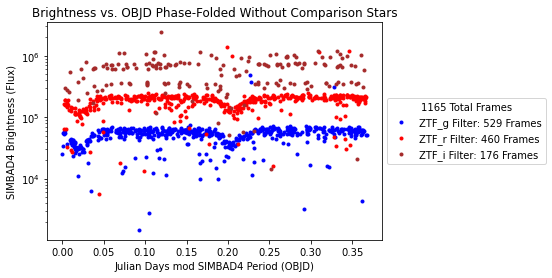

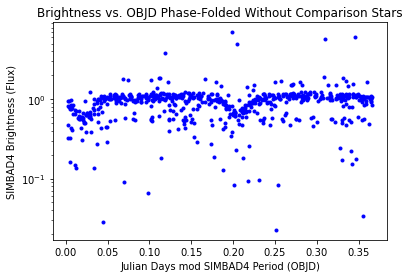

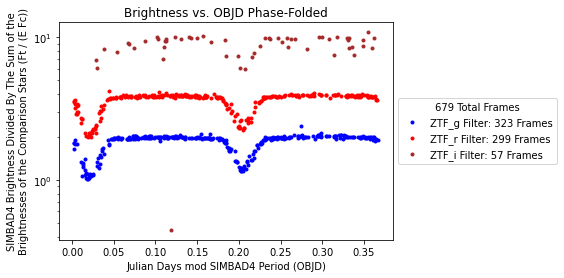

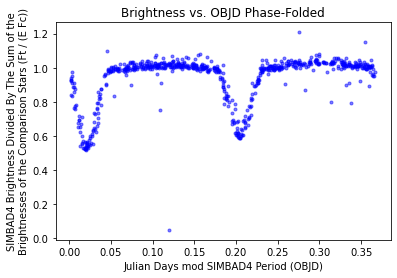

In [29]:
# Plotting the lightcurve!!!


all_star_data = pd.read_csv("All_Star_Data_2.csv") # All_Star_Data_BEFORE_GETTING_RID_OF_FOR-LOOP # _individual_gaussian
comparison_star_headers = ["155657569_brightness", "155657576_brightness", "155657581_brightness"] #all_star_data.columns[9::3] # NEEDS TO BE 9 IN NEW THING AND 12 IN OLD THINGS
#print(list(comparison_star_headers)) # All of the stars that could share the same time


plot_times = {"ZTF_r": [], "ZTF_g": [], "ZTF_i": []}
plot_brightnesses = {"ZTF_r": [], "ZTF_g": [], "ZTF_i": []}

plot_times_comparison = {"ZTF_r": [], "ZTF_g": [], "ZTF_i": []}
plot_brightnesses_comparison = {"ZTF_r": [], "ZTF_g": [], "ZTF_i": []}


skip_count = 0
'''for time_index in range(len(all_star_data["time"])):
    if not (str(all_star_data[comparison_star_headers[0]][time_index]) == "nan") and not (str(all_star_data[comparison_star_headers[1]][time_index]) == "nan"):
        if (all_star_data["image_filter"][time_index] == "ZTF_g") or (all_star_data["image_filter"][time_index] == "ZTF g"):
            plot_times_comparison["ZTF_g"].append(all_star_data["time"][time_index] % period)
            plot_brightnesses_comparison["ZTF_g"].append((all_star_data["target_brightness"][time_index]) / ((all_star_data[comparison_star_headers[0]][time_index]) + (all_star_data[comparison_star_headers[1]][time_index])))
        elif (all_star_data["image_filter"][time_index] == "ZTF_r") or (all_star_data["image_filter"][time_index] == "ZTF r"):
            plot_times_comparison["ZTF_r"].append(all_star_data["time"][time_index] % period)
            plot_brightnesses_comparison["ZTF_r"].append((all_star_data["target_brightness"][time_index]) / ((all_star_data[str(comparison_star_headers[0])][time_index]) + (all_star_data[str(comparison_star_headers[1])][time_index])))
        elif (all_star_data["image_filter"][time_index] == "ZTF_i") or (all_star_data["image_filter"][time_index] == "ZTF i"):
            plot_times_comparison["ZTF_i"].append(all_star_data["time"][time_index] % period)
            plot_brightnesses_comparison["ZTF_i"].append((all_star_data["target_brightness"][time_index]) / ((all_star_data[str(comparison_star_headers[0])][time_index]) + (all_star_data[str(comparison_star_headers[1])][time_index])))
        else:
            print("Unknown filter: " + str(all_star_data["image_filter"][time_index]))
    else:
        skip_count += 1
    
    if (all_star_data["image_filter"][time_index] == "ZTF_g") or (all_star_data["image_filter"][time_index] == "ZTF g"):
        plot_times["ZTF_g"].append(all_star_data["time"][time_index] % period)
        plot_brightnesses["ZTF_g"].append(all_star_data["target_brightness"][time_index])
    elif (all_star_data["image_filter"][time_index] == "ZTF_r") or (all_star_data["image_filter"][time_index] == "ZTF r"):
        plot_times["ZTF_r"].append(all_star_data["time"][time_index] % period)
        plot_brightnesses["ZTF_r"].append(all_star_data["target_brightness"][time_index])
    elif (all_star_data["image_filter"][time_index] == "ZTF_i") or (all_star_data["image_filter"][time_index] == "ZTF i"):
        plot_times["ZTF_i"].append(all_star_data["time"][time_index] % period)
        plot_brightnesses["ZTF_i"].append(all_star_data["target_brightness"][time_index])
    else:
        print("Unknown filter: " + str(all_star_data["image_filter"][time_index]))'''
for time_index in range(len(all_star_data["time"])):
    if not (str(all_star_data[comparison_star_headers[0]][time_index]) == "nan") and not (str(all_star_data[comparison_star_headers[1]][time_index]) == "nan"):
        if (all_star_data["image_filter"][time_index] == "ZTF_g") or (all_star_data["image_filter"][time_index] == "ZTF g"):
            plot_times_comparison["ZTF_g"].append(all_star_data["time"][time_index] % period)
            plot_brightnesses_comparison["ZTF_g"].append((all_star_data[str(comparison_star_headers[2])][time_index]) / ((all_star_data[comparison_star_headers[0]][time_index]) + (all_star_data[comparison_star_headers[1]][time_index])))
        elif (all_star_data["image_filter"][time_index] == "ZTF_r") or (all_star_data["image_filter"][time_index] == "ZTF r"):
            plot_times_comparison["ZTF_r"].append(all_star_data["time"][time_index] % period)
            plot_brightnesses_comparison["ZTF_r"].append((all_star_data[str(comparison_star_headers[2])][time_index]) / ((all_star_data[str(comparison_star_headers[0])][time_index]) + (all_star_data[str(comparison_star_headers[1])][time_index])))
        elif (all_star_data["image_filter"][time_index] == "ZTF_i") or (all_star_data["image_filter"][time_index] == "ZTF i"):
            plot_times_comparison["ZTF_i"].append(all_star_data["time"][time_index] % period)
            plot_brightnesses_comparison["ZTF_i"].append((all_star_data[str(comparison_star_headers[2])][time_index]) / ((all_star_data[str(comparison_star_headers[0])][time_index]) + (all_star_data[str(comparison_star_headers[1])][time_index])))
        else:
            print("Unknown filter: " + str(all_star_data["image_filter"][time_index]))
    else:
        skip_count += 1
    
    if (all_star_data["image_filter"][time_index] == "ZTF_g") or (all_star_data["image_filter"][time_index] == "ZTF g"):
        plot_times["ZTF_g"].append(all_star_data["time"][time_index] % period)
        plot_brightnesses["ZTF_g"].append(all_star_data[str(comparison_star_headers[2])][time_index])
    elif (all_star_data["image_filter"][time_index] == "ZTF_r") or (all_star_data["image_filter"][time_index] == "ZTF r"):
        plot_times["ZTF_r"].append(all_star_data["time"][time_index] % period)
        plot_brightnesses["ZTF_r"].append(all_star_data[str(comparison_star_headers[2])][time_index])
    elif (all_star_data["image_filter"][time_index] == "ZTF_i") or (all_star_data["image_filter"][time_index] == "ZTF i"):
        plot_times["ZTF_i"].append(all_star_data["time"][time_index] % period)
        plot_brightnesses["ZTF_i"].append(all_star_data[str(comparison_star_headers[2])][time_index])
    else:
        print("Unknown filter: " + str(all_star_data["image_filter"][time_index]))

print("Skipped " + str(skip_count) + " out of " + str(len(all_star_data["time"])))


# Without comparison stars
figure, ax = plot.subplots()
ax.plot(plot_times["ZTF_g"], plot_brightnesses["ZTF_g"], ".", color = "b", label = "ZTF_g Filter: " + str(len(plot_times["ZTF_g"])) + " Frames")
ax.plot(plot_times["ZTF_r"], plot_brightnesses["ZTF_r"], ".", color = "r", label = "ZTF_r Filter: " + str(len(plot_times["ZTF_r"])) + " Frames")
ax.plot(plot_times["ZTF_i"], plot_brightnesses["ZTF_i"], ".", color = "brown", label = "ZTF_i Filter: " + str(len(plot_times["ZTF_i"])) + " Frames")
ax.set_xlabel("Julian Days mod SIMBAD4 Period (OBJD)")
ax.set_yscale("log")
ax.set_ylabel("SIMBAD4 Brightness (Flux)")
ax.legend(loc = "center left", bbox_to_anchor = (1, 0.5), title = str(len(plot_times["ZTF_g"]) + len(plot_times["ZTF_r"]) + len(plot_times["ZTF_i"])) + " Total Frames")
ax.set_title("Brightness vs. OBJD Phase-Folded Without Comparison Stars")
plot.show()

figure, ax = plot.subplots()
ax.plot(plot_times["ZTF_g"], plot_brightnesses["ZTF_g"] / np.median(plot_brightnesses["ZTF_g"]), ".", color = "b")
ax.plot(plot_times["ZTF_r"], plot_brightnesses["ZTF_r"] / np.median(plot_brightnesses["ZTF_r"]), ".", color = "b")
ax.plot(plot_times["ZTF_i"], plot_brightnesses["ZTF_i"] / np.median(plot_brightnesses["ZTF_i"]), ".", color = "b")
ax.set_xlabel("Julian Days mod SIMBAD4 Period (OBJD)")
ax.set_yscale("log")
ax.set_ylabel("SIMBAD4 Brightness (Flux)")
ax.set_title("Brightness vs. OBJD Phase-Folded Without Comparison Stars")
plot.show()


# With comparison stars
figure, ax = plot.subplots()
ax.plot(plot_times_comparison["ZTF_g"], plot_brightnesses_comparison["ZTF_g"], ".", color = "b", label = "ZTF_g Filter: " + str(len(plot_times_comparison["ZTF_g"])) + " Frames")
ax.plot(plot_times_comparison["ZTF_r"], plot_brightnesses_comparison["ZTF_r"], ".", color = "r", label = "ZTF_r Filter: " + str(len(plot_times_comparison["ZTF_r"])) + " Frames")
ax.plot(plot_times_comparison["ZTF_i"], plot_brightnesses_comparison["ZTF_i"], ".", color = "brown", label = "ZTF_i Filter: " + str(len(plot_times_comparison["ZTF_i"])) + " Frames")
ax.set_xlabel("Julian Days mod SIMBAD4 Period (OBJD)")
ax.set_yscale("log")
ax.set_ylabel("SIMBAD4 Brightness Divided By The Sum of the\nBrightnesses of the Comparison Stars (Ft / (E Fc))")
ax.legend(loc = "center left", bbox_to_anchor = (1, 0.5), title = str(len(plot_times_comparison["ZTF_g"]) + len(plot_times_comparison["ZTF_r"]) + len(plot_times_comparison["ZTF_i"])) + " Total Frames")
ax.set_title("Brightness vs. OBJD Phase-Folded")
plot.show()

figure, ax = plot.subplots()
ax.plot(plot_times_comparison["ZTF_g"], plot_brightnesses_comparison["ZTF_g"] / np.median(plot_brightnesses_comparison["ZTF_g"]), ".", color = "b", alpha = 0.5)
ax.plot(plot_times_comparison["ZTF_r"], plot_brightnesses_comparison["ZTF_r"] / np.median(plot_brightnesses_comparison["ZTF_r"]), ".", color = "b", alpha = 0.5)
ax.plot(plot_times_comparison["ZTF_i"], plot_brightnesses_comparison["ZTF_i"] / np.median(plot_brightnesses_comparison["ZTF_i"]), ".", color = "b", alpha = 0.5)
ax.set_xlabel("Julian Days mod SIMBAD4 Period (OBJD)")
#ax.set_yscale("log")
ax.set_ylabel("SIMBAD4 Brightness Divided By The Sum of the\nBrightnesses of the Comparison Stars (Ft / (E Fc))")
ax.set_title("Brightness vs. OBJD Phase-Folded")
plot.show()

# g = A * e^(- (((x - x0)^2 / (2 sigma x^2)) + ((y - y0)^2 / (2 sigma y^2)))) * e^(something for changing theta) + c

[ 454.86414677    9.43362598    1.19480537    9.79362655    1.3056831
 -238.44144901  220.35878902]
454.86414677003995


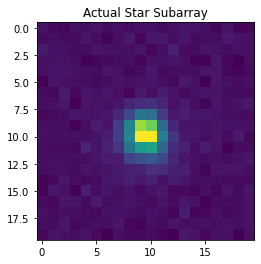

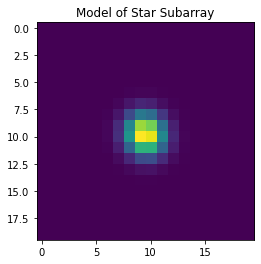

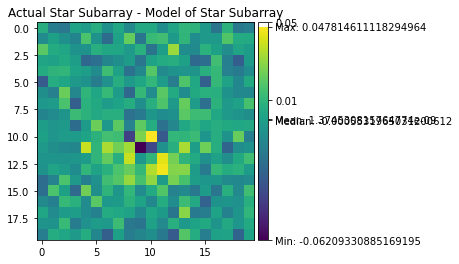

In [424]:
# Making a 2D gaussian fit

def create_2D_gaussian(x_data_tuple, parameters): # Creating the 2D gaussian
    (x, y) = x_data_tuple 
    
    amplitude, x0, sigma_x, y0, sigma_y, theta, offset = parameters
    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    
    g = offset + amplitude*np.exp( - (a*((x-x0)**2) + 2*b*(x-x0)*(y-y0)+ c*((y-y0)**2)))
    return g.ravel()


def myfunct(parameters, fjac = None, x = None, y = None, err = None, brightness = None):
    # If fjac == None, then partial derivatives should not be computed. It will always be None if MPFIT is called with default flag
    model = create_2D_gaussian((x, y), parameters)
    # Non-negative status value means MPFIT should continue, negative means stop the calculation
    status = 0
    return [status, ((brightness - model.reshape(int(math.sqrt(data.shape[0])), int(math.sqrt(data.shape[0]))))).reshape(data.shape[0])]


# Generate data
parameters = [30000, 10, 2, 10, 2, 0, 100] # A (amplitude -- like the brightest pixel - the noise), x0 (actual x center of star), y0 (actual y center of star), sigma_x (half the width of the star in the x direction), sigma_y (half the width of the star in the y direction), c (vertical shift -- noise)

# Getting .fits file information into easier-to-use numpy arrays and dictionaries
fits_URL = "SIMBAD4_Images/342_3/ztf_20200103524711_000862_zg_c14_o_q3_frame3_sciimg.fits"
fits_file = fits.open(fits_URL) # fits can open URLS directly without needing to save the data as a .fits file")
fits_image = np.array(fits_file[0].data)
fits_header = fits_file[0].header

# Setting the pixel coordinate edges from the shape of the .fits file
target_w = WCS(fits_header)
#target_px, target_py = target_w.wcs_world2pix(float(ra), float(dec), 1)
#target_px, target_py = target_w.wcs_world2pix(float(206.422233922412), float(79.3514599041794), 1)
target_px, target_py = target_w.wcs_world2pix(float(206.420747734342), float(79.3740998898516), 1)
SIMBAD4_subarray = fits_image[int(target_py) - 10 : int(target_py) + 10, int(target_px) - 10 : int(target_px) + 10]
x = np.arange(SIMBAD4_subarray.shape[0]) # Columns of subarray -- NOT BRIGHTNESSES
y = np.arange(SIMBAD4_subarray.shape[1]) # Rows of subarray -- NOT BRIGHTNESSES
x, y = np.meshgrid(x, y)

data = create_2D_gaussian((x, y), parameters)

start_parameters = parameters # Choose starting values for parameter you are trying to fit. Roughly like what they should be
parameters_info = [ # Step sizes for parameters. If fixed == True, then it will stay constant and not fit for that parameter, so we want all of them to be False
    {"fixed": False, "step": 1e1, "mpprint": 0} # Amplitude
    , {"fixed": False, "step": 1e-2, "mpprint": 0} # x0
    , {"fixed": False, "step": 1e-3, "mpprint": 0} # sigma_x
    , {"fixed": False, "step": 1e-2, "mpprint": 0} # y0
    , {"fixed": False, "step": 1e-3, "mpprint": 0} # sigma_y
    , {"fixed": False, "step": 1e-2, "mpprint": 0} # Theta
    , {"fixed": False, "step": 1e0, "mpprint": 0} # Offset
]
# use mpyfit with brightest pixel

fa = {"x": x, "y": y, "brightness": SIMBAD4_subarray}
model = mpfit(myfunct, start_parameters, functkw = fa, parinfo = parameters_info, maxiter = 100, nprint = 0, quiet = "quiet")
#print(model.params)

data_fitted = create_2D_gaussian((x, y), model.params)
print(model.params)
print(model.params[0])

plot.imshow(SIMBAD4_subarray)
plot.title("Actual Star Subarray")
plot.show()
plot.imshow(data_fitted.reshape(int(math.sqrt(data.shape[0])), int(math.sqrt(data.shape[0]))))
plot.title("Model of Star Subarray")
plot.show()

figure, ax = plot.subplots()
img = ax.imshow((np.array(SIMBAD4_subarray) - np.array(data_fitted.reshape(int(math.sqrt(data.shape[0])), int(math.sqrt(data.shape[0]))))) / (np.max(data_fitted)))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size = "5%", pad = 0.05)
colorbar = figure.colorbar(img, cax = cax, orientation = "vertical")
colorbar.set_ticks([0.01, 0.05, np.mean((np.array(SIMBAD4_subarray) - np.array(data_fitted.reshape(int(math.sqrt(data.shape[0])), int(math.sqrt(data.shape[0]))))) / (np.max(data_fitted))), np.median((np.array(SIMBAD4_subarray) - np.array(data_fitted.reshape(int(math.sqrt(data.shape[0])), int(math.sqrt(data.shape[0]))))) / (np.max(data_fitted))), np.max((np.array(SIMBAD4_subarray) - np.array(data_fitted.reshape(int(math.sqrt(data.shape[0])), int(math.sqrt(data.shape[0]))))) / (np.max(data_fitted))), np.min((np.array(SIMBAD4_subarray) - np.array(data_fitted.reshape(int(math.sqrt(data.shape[0])), int(math.sqrt(data.shape[0]))))) / (np.max(data_fitted)))])
colorbar.set_ticklabels([str(0.01), str(0.05), "Mean: " + str(np.mean((np.array(SIMBAD4_subarray) - np.array(data_fitted.reshape(int(math.sqrt(data.shape[0])), int(math.sqrt(data.shape[0]))))) / (np.max(data_fitted)))), "Median: " + str(np.median((np.array(SIMBAD4_subarray) - np.array(data_fitted.reshape(int(math.sqrt(data.shape[0])), int(math.sqrt(data.shape[0]))))) / (np.max(data_fitted)))), "Max: " + str(np.max((np.array(SIMBAD4_subarray) - np.array(data_fitted.reshape(int(math.sqrt(data.shape[0])), int(math.sqrt(data.shape[0]))))) / (np.max(data_fitted)))), "Min: " + str(np.min((np.array(SIMBAD4_subarray) - np.array(data_fitted.reshape(int(math.sqrt(data.shape[0])), int(math.sqrt(data.shape[0]))))) / (np.max(data_fitted))))])
ax.set_title("Actual Star Subarray - Model of Star Subarray")
plot.show()

## base_url = "https://fallingstar-data.com/forcedphot"
%run Passwords.ipynb

response = requests.post(url = str(base_url) + "/api-token-auth/", data = {"username": username, "password": password})
ra = 44
dec = 22
task_url = ""

if response.status_code == 200:
    token = response.json()["token"]
    print("Token: " + str(token))
    headers = {"Authorization": "Token " + str(token), "Accept": "application/json"}
    
    task_url = None
    while not task_url:
        with requests.Session() as session:
            response = session.post(str(base_url) + "/queue/", headers = headers, data = {"ra": ra, "dec": dec, "mjd_min": 59248., "send_email": False})
            
            if response.status_code == 201:  # Successfull!
                task_url = response.json()["url"]
                print("Task URL: " + str(task_url))
                
                response = requests.get(task_url, allow_redirects = True)
                open("test.txt", "wb").write(response.content)
            elif response.status_code == 429:  # Wait
                message = response.json()["detail"]
                print("ERROR: " + str(response.status_code))
                print(response.json())
                seconds = re.findall(r'available in (\d+) seconds', message)
                minutes = re.findall(r'available in (\d+) minutes', message)
                wait_time = 0
                if t_sec:
                    wait_time = int(seconds[0])
                elif t_min:
                    wait_time = int(minutes[0]) * 60
                else:
                    wait_time = 10
                print("Waiting " + str(wait_time) + " seconds...")
                time.sleep(wait_time)
            else: # Fail
                print("ERROR: " + str(response.status_code))
                print(response.json())
                sys.exit()
else:
    print("ERROR: " + str(response.status_code))
    print(response.json())

In [ ]:
result_url = None
while not result_url:
    with requests.Session() as session:
        response = session.get(task_url, headers = headers)
        
        if response.status_code == 200: # HTTP OK
            if response.json()["finishtimestamp"]:
                result_url = response.json()["result_url"]
                print("Result URL: " + str(result_url))
                break
            elif response.json()["starttimestamp"]:
                print("Task is running (started at " + str(response.json()["starttimestamp"]))
            else:
                print("Waiting 10 seconds...")
                time.sleep(10)
        else:
            print("ERROR: " + str(response.status_code))
            print(response.json())
            sys.exit()


panda_result = ""

with requests.Session() as session:
    textdata = session.get(result_url, headers = headers).text
    #print(textdata)
    
    session.delete(task_url, headers = headers).json() # De-clutter sessions
    
    panda_result = pd.read_csv(io.StringIO(textdata.replace("###", "")), delim_whitespace = True)
    print(panda_result)